# Customer Segmentation Analysis on Brazilian Olist Dataset

This notebook explores customer purchasing behavior using the RFM (Recency, Frequency, Monetary) model. By segmenting customers and analyzing their preferences, geography, and engagement patterns, we uncover actionable insights to drive retention, loyalty, and growth.



### The project follows a standard data analysis workflow:
1. Data Loading and Merging: Loading all relevant datasets and combining them into a single DataFrame for unified analysis.
2. Data Cleaning and Preparation: Ensuring data types are correct and handling any missing values to prepare for calculations.
3. RFM Calculation: Computing the Recency, Frequency, and Monetary values for each unique customer.
4. Exploratory Data Analysis (EDA): Visualizing the distribution of RFM metrics to understand the underlying data patterns and distributions.
5. Customer Segmentation: Assigning customers to specific segments based on their RFM scores.
6. Segment Profiling: Analyzing the characteristics of each customer segment to derive actionable business insights.

# Part 1: Data Preparation & RFM Calculation

We begin by loading and merging multiple datasets to create a unified view of customer transactions. This includes orders, customers, products, and reviews. Cleaning ensures accurate timestamps and removes missing values. after this we start our rfm metrics calculation


In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# we'll Set the visualization style for professional-looking plots.
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

###  Step 1: Load Datasets

We load multiple CSV files—orders, customers, items, products, and translations. Each dataset is a puzzle piece that contributes to our full view of customer behavior.


In [3]:
orders_df = pd.read_csv("olist_orders_dataset.csv")
customers_df = pd.read_csv("olist_customers_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
translation_df = pd.read_csv("product_category_name_translation.csv")

### Step 2: Merge Datasets

We join the datasets to create a unified DataFrame. This includes:
- Linking orders to customers
- Calculating total revenue per order
- Translating product categories
- Merging product and item details

This consolidated view is essential for accurate RFM analysis.


In [4]:
#  First, we connect orders to customers using the 'customer_id' column.
merged_df = pd.merge(orders_df, customers_df, on='customer_id')
print("\nMerging dataframes...")


Merging dataframes...


In [5]:
# Next, we need to calculate the total revenue for each order.
# We group the `order_items_df` by 'order_id' and sum the `price` column.
order_revenue_df = order_items_df.groupby('order_id').agg(
    total_price=('price', 'sum')
).reset_index()
order_revenue_df

,order_id,total_price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99
98662,fffcd46ef2263f404302a634eb57f7eb,350.00
98663,fffce4705a9662cd70adb13d4a31832d,99.90
98664,fffe18544ffabc95dfada21779c9644f,55.99


In [6]:
# Now, we merge this revenue data into our main table.
final_df = pd.merge(merged_df, order_revenue_df, on='order_id')

In [7]:
#  To make our product categories readable, we'll use the translation file.
product_data_df = pd.merge(products_df, translation_df, on='product_category_name')

In [8]:
# Finally, we add the product and item details to our main table.
final_df = pd.merge(final_df, order_items_df, on='order_id')
final_df = pd.merge(final_df, product_data_df, on='product_id')


###  Step 3: Clean & Prepare Data

We ensure timestamps are in proper datetime format and check for missing values. Clean data is the foundation of reliable insights.


In [9]:
#A crucial step in data cleaning is to ensure our columns have the correct data type.
# For dates, we must convert them to a proper datetime format.
final_df['order_purchase_timestamp'] = pd.to_datetime(final_df['order_purchase_timestamp'])

In [10]:
# A quick check for missing values.
print("Checking for any missing values in our most important columns:")
print(final_df[['order_id', 'customer_unique_id', 'total_price', 'order_purchase_timestamp']].isnull().sum())

Checking for any missing values in our most important columns:
order_id                    0
customer_unique_id          0
total_price                 0
order_purchase_timestamp    0
dtype: int64


### Step 4: Calculating RFM and Exploring the Data


Now that our data is clean and ready,We define a snapshot date (one day after the last purchase) and  we can calculate our RFM metrics.
What is RFM?

- **Recency**:How recently did the customer make a purchase? (A recent buyer is a good sign!)
- **Frequency**:How often does the customer buy? (More frequent buyers are more engaged!)
- **Monetary**: How much money does the customer spend? (High spenders are valuable!)

The RFM (Recency, Frequency, Monetary) model is a powerful marketing technique used to quantitatively analyze and segment customers based on their purchasing behavior. I've chosen this model because it is highly effective for e-commerce datasets like this, allowing us to identify and target our most valuable customers

In [11]:
# We need a "snapshot date" to calculate Recency. This is the date we're "freezing" our analysis.
# We'll use one day after the last purchase to get a meaningful "days since last purchase" count.
snapshot_date = final_df['order_purchase_timestamp'].max() + timedelta(days=1)

In [12]:
# We group the entire dataset by each unique customer to get their RFM score.
rfm_df = final_df.groupby('customer_unique_id').agg(
    # Recency is the number of days between our snapshot date and their last purchase.
    Recency=('order_purchase_timestamp', lambda x: (snapshot_date - x.max()).days),
    # Frequency is the count of how many times they've placed an order.
    Frequency=('order_id', 'count'),
    # Monetary is the sum of all their order prices.
    Monetary=('total_price', 'sum')
).reset_index()


# Part 2: Exploratory Data Analysis (EDA)

###  Step 5: Exploring RFM Metric Distributions

Before segmenting customers, we need to understand how Recency, Frequency, and Monetary values are distributed. These histograms help us detect skewness, outliers, and behavioral patterns across the customer base.

#### 🔍 Why These Visuals?
- **Recency**: Reveals how recently customers made purchases.
- **Frequency**: Shows how often customers buy.
- **Monetary**: Highlights spending behavior.

Understanding these distributions helpsus identify behavioral patterns and outliers, it also helps us design smarter segmentation rules.

Histograms help you understand the skew and spread of your data.
This is a key part of Exploratory Data Analysis (EDA)

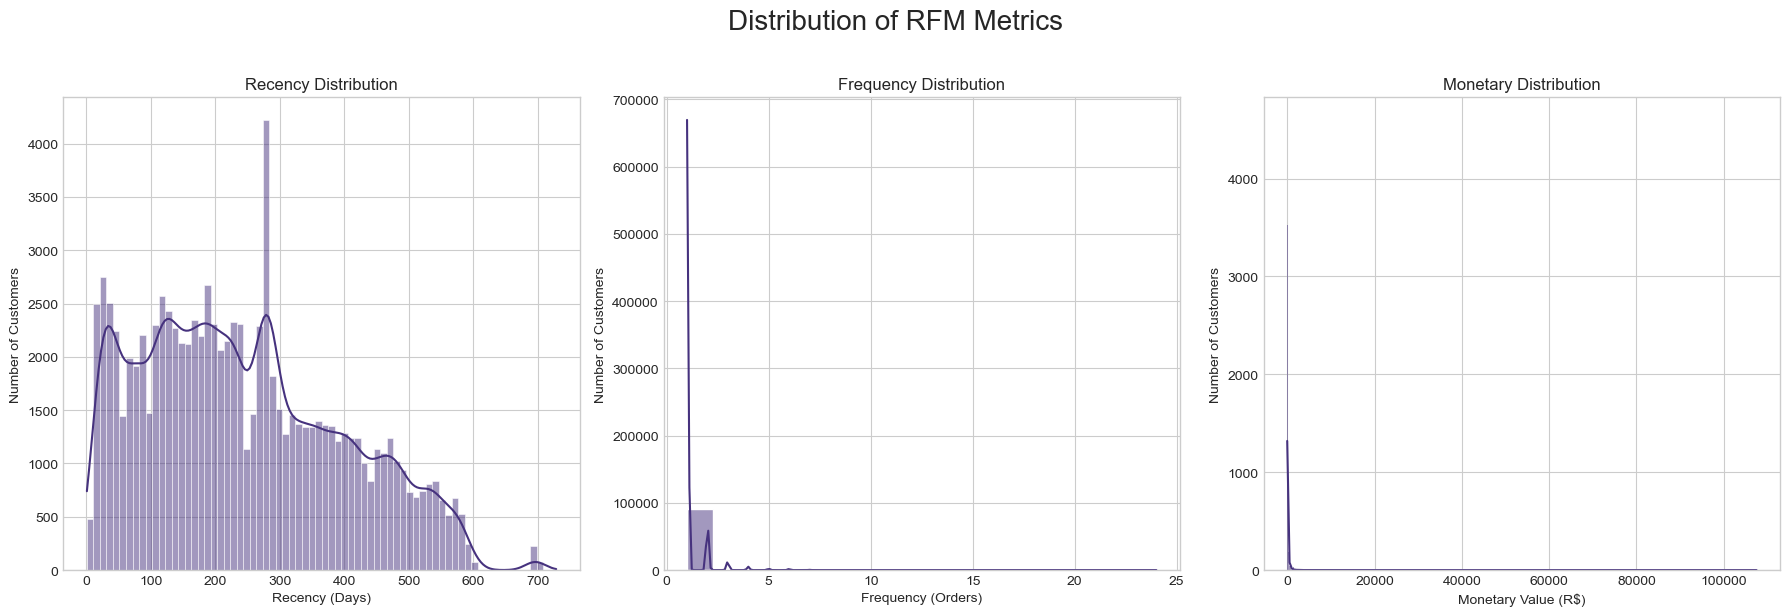

In [13]:
# Set a stylish color palette for the plots
sns.set_palette("viridis")

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribution of RFM Metrics', fontsize=20, y=1.02)

# Recency Distribution
sns.histplot(rfm_df['Recency'], kde=True, ax=axes[0])
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Recency (Days)')
axes[0].set_ylabel('Number of Customers')

# Frequency Distribution
sns.histplot(rfm_df['Frequency'], kde=True, ax=axes[1])
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Frequency (Orders)')
axes[1].set_ylabel('Number of Customers')

# Monetary Distribution
sns.histplot(rfm_df['Monetary'], kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Monetary Value (R$)')
axes[2].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()


### Key Findings

:

- **Recency**: Most customers haven't purchased recently, indicating potential churn.
- **Frequency**: Majority placed only one order—low repeat engagement.
- **Monetary**: Spending varies widely, with a few high-value customers skewing the distribution.

# Part 3: RFM Scoring & Segmentation

###  Step 6: RFM Scoring and Customer Segmentation

Now we transform raw RFM metrics into meaningful customer segments. Using quintiles, we assign scores from 1 to 5 for each metric:
- **Recency**: Lower is better → [5, 4, 3, 2, 1]
- **Frequency & Monetary**: Higher is better → [1, 2, 3, 4, 5]

These scores allow us to classify customers based on engagement and value.


#### Why Segment Customers?
Segmenting customers based on RFM scores allows us to group them by value and engagement. This enables targeted marketing strategies and personalized experiences.
This is where the magic happens and we get our business insights.


We use `pd.qcut` to divide customers into 5 equal groups (quintiles) for each metric.


In [14]:
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

###  Step 7: Segment Mapping Logic
Based on RFM scores, customers will be grouped into meaningful segments:

-  **Champions**: Recent, frequent, high spenders  
-  **Loyal Customers**: Consistent buyers  
-  **New Customers**: Recent but low frequency  
-  **Potential Loyalists**: Moderate frequency, recent buyers  
-  **At Risk**: Previously active, now inactive  
-  **Lost Customers**: Long inactive, low value  

This segmentation enables targeted marketing and retention strategies.

- Champions and Loyal Customers are active and valuable.
- At Risk and Lost, Customers show signs of disengagement.
- New Customers need nurturing to become loyal.


In [15]:
# We will create a simple function to map combinations of
# RFM scores to a specific, business-friendly customer segment.
def rfm_segment(row):
    if row['R_Score'] in [4, 5] and row['F_Score'] in [4, 5]:
        return 'Champions' # Our best customers! They buy recently and frequently.
    elif row['R_Score'] in [4, 5] and row['F_Score'] in [3]:
        return 'Loyal Customers' # Consistent and recent buyers.
    elif row['R_Score'] in [4, 5] and row['F_Score'] in [1, 2]:
        return 'New Customers' # They've just started buying. We need to nurture them.
    elif row['R_Score'] in [2, 3] and row['F_Score'] in [3, 4]:
        return 'Potential Loyalist' # Customers with good Frequency who could become loyal.
    elif row['R_Score'] in [1, 2] and row['F_Score'] in [4, 5]:
        return 'At Risk' # They used to be frequent, but haven't bought recently.
    elif row['R_Score'] in [1, 2] and row['F_Score'] in [1, 2]:
        return 'Lost Customers' # They haven't bought in a long time. It might be time to let go.
    else:
        return 'Others'

In [16]:
# We apply our function to create the 'RFM_Segment' column.
rfm_df['RFM_Segment'] = rfm_df.apply(rfm_segment, axis=1)

### Step 7: Segment Profiling
Now we go deeper to understand what makes each segment unique.



In [17]:
# Now Let's see how many customers fall into each segment.
print("\nCustomer Distribution by RFM Segment:")
segment_distribution = rfm_df['RFM_Segment'].value_counts().reset_index()
segment_distribution.columns = ['RFM Segment', 'Customer Count']
print(segment_distribution)


Customer Distribution by RFM Segment:
          RFM Segment  Customer Count
0           Champions           15197
1       New Customers           15171
2  Potential Loyalist           15060
3      Lost Customers           15031
4              Others           14890
5             At Risk           11225
6     Loyal Customers            7514


####  Segment Distribution

This table shows how many customers fall into each segment. It helps us understand the size and potential impact of each group.

- **Champions** and **New Customers** dominate the base.
- **At Risk** and **Lost Customers** represent major recovery opportunities.


# Part 3: Segment Profiling & Visualizations

###  Step 8: Segment Profiling with Visuals

To understand each customer segment deeply, we visualize their average Recency, Frequency, and Monetary values. We will use a  bar chart to  compare segment performance side by side.

####  Why This Matters
- Highlights which segments are most valuable
- Reveals which groups need re-engagement
- Supports data-driven marketing decisions


In [18]:
# Group by segment and calculate the mean RFM metrics. This helps us understand
# the average behavior of customers in each group.
segment_metrics = rfm_df.groupby('RFM_Segment').agg(
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean')
).sort_values(by='Avg_Monetary', ascending=False)
print("\nAverage RFM Metrics per Segment (to understand each group):")
print(segment_metrics.round(2))


Average RFM Metrics per Segment (to understand each group):
                    Avg_Recency  Avg_Frequency  Avg_Monetary
RFM_Segment                                                 
At Risk                  425.69           1.59        301.97
Champions                 95.29           1.47        258.74
Others                   288.86           1.22        183.51
New Customers             95.40           1.00        134.63
Loyal Customers           95.70           1.00        133.66
Lost Customers           401.73           1.00        132.35
Potential Loyalist       273.72           1.00        127.42


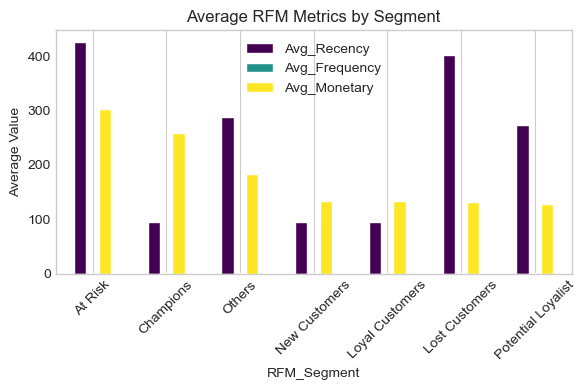

In [19]:
segment_metrics.plot(kind='bar', figsize=(6,4), colormap='viridis')
plt.title('Average RFM Metrics by Segment')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


###  Key Insights from Bar Chart
- **At Risk** customers have the highest average spend—ideal for reactivation.
- **Champions** are recent and frequent buyers with strong monetary value.
- **Lost Customers** show long inactivity and low frequency, signaling churn.


###  Step 9: Segment Distribution Overview

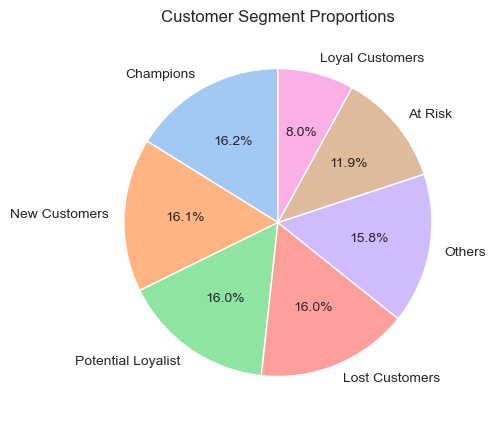

In [20]:
segment_distribution.set_index('RFM Segment').plot.pie(
    y='Customer Count',
    autopct='%1.1f%%',
    figsize=(5, 5),
    legend=False,
    startangle=90,
    colors=sns.color_palette('pastel')
)
plt.title('Customer Segment Proportions')
plt.ylabel('')
plt.show()


The pie chart shows the proportion of customers in each segment. It helps visualize the distribution and identify which groups dominate the customer base.

####  Key Insights from Pie Chart
- **Champions** and **New Customers** form a large portion of the base.
- **At Risk** and **Lost Customers** represent major opportunities for win-back campaigns.


##  Step 10: Segment Profiles via Radar Chart

Next we use radar chart to compare normalized RFM metrics across segments. It reveals behavioral patterns and helps profile each group holistically.

#### 🔍 Why This Matters
- Visualizes strengths and weaknesses per segment
- Supports tailored engagement strategies
- Highlights potential growth areas


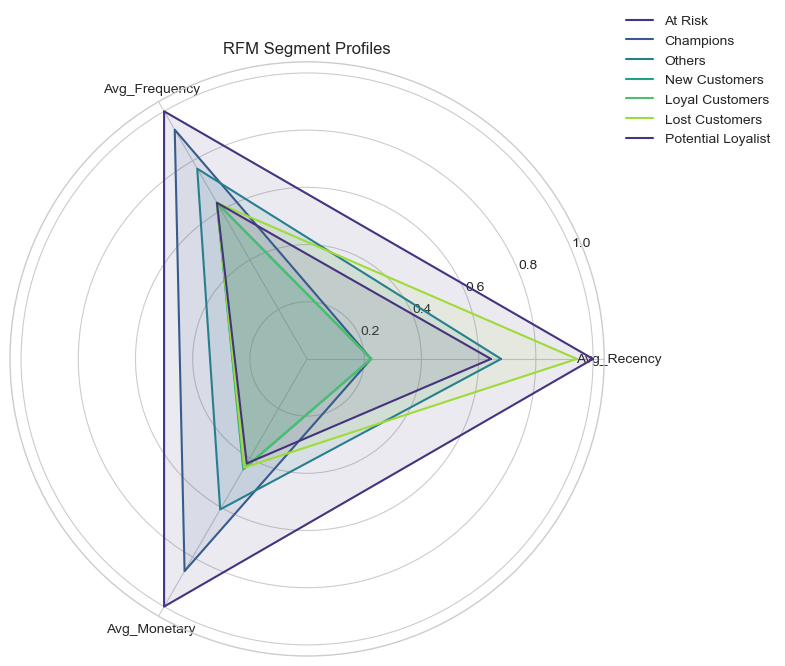

In [21]:
from math import pi

# Normalize values
radar_df = segment_metrics.reset_index()
radar_df.set_index('RFM_Segment', inplace=True)
radar_df = radar_df / radar_df.max()

# Prepare data for radar chart
labels = radar_df.columns.tolist()
num_vars = len(labels)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx, row in radar_df.iterrows():
    values = row.tolist()
    values += values[:1]  # repeat first value to close the circle
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    ax.plot(angles, values, label=idx)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('RFM Segment Profiles')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


#### Key Findings

- Champions score high across all metrics.
- Lost Customers lag in all dimensions.
- Potential Loyalists show promise with moderate scores.


## 🎯 Step 11: Segment Spread – Frequency vs. Monetary

This scatterplot maps customers by purchase frequency and total spend, colored by segment. It shows how engagement and value vary across the base.

#### 🔍 Why This Matters
- Identifies high-value clusters
- Reveals low-engagement zones
- Supports targeted outreach


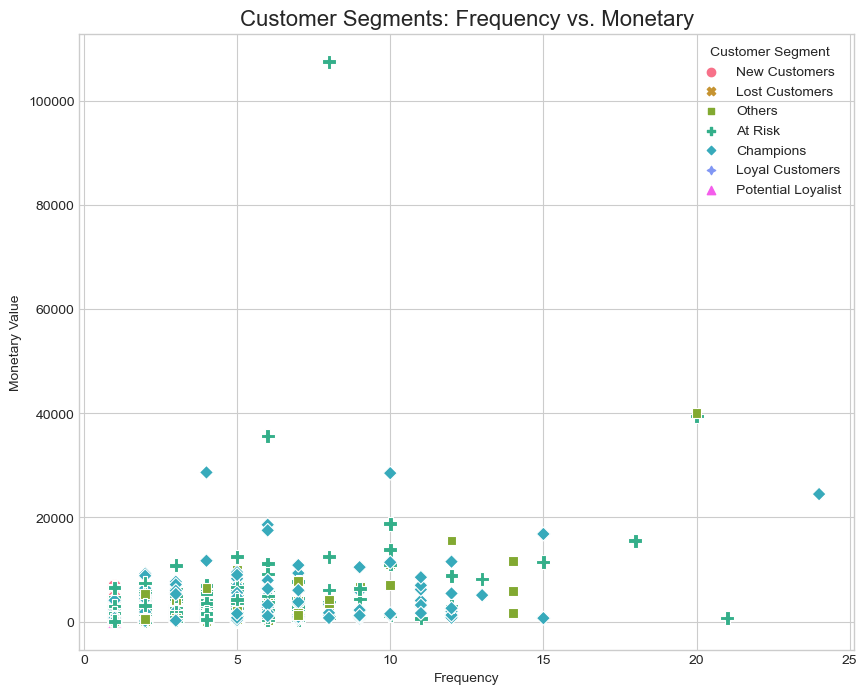

Scatterplot for customer segments generated successfully!


In [22]:
sns.set_palette("viridis")
plt.style.use('seaborn-v0_8-whitegrid')


plt.figure(figsize=(10, 8))
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='RFM_Segment', style='RFM_Segment', s=100)
plt.title('Customer Segments: Frequency vs. Monetary', fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.legend(title='Customer Segment')
plt.grid(True)
plt.show()

print("Scatterplot for customer segments generated successfully!")


**Key Insights**:
- **Champions** and **Loyal Customers** cluster in the upper-right quadrant, indicating high frequency and high spending.
- **New Customers** show low frequency but moderate monetary value, suggesting potential for growth.
- **Lost Customers** and **At Risk** segments tend to fall in the lower-left quadrant, highlighting low engagement and spend.
- The visual separation of segments helps identify which groups are most valuable and which need re-engagement strategies.

##  Step 12: Segment Heatmap – Average RFM Metrics

This heatmap displays the average Recency, Frequency, and Monetary scores for each segment. Color intensity reflects metric strength.

####  Why This Matters
- Quickly compares segment performance
- Highlights retention and upsell targets
- Supports strategic planning


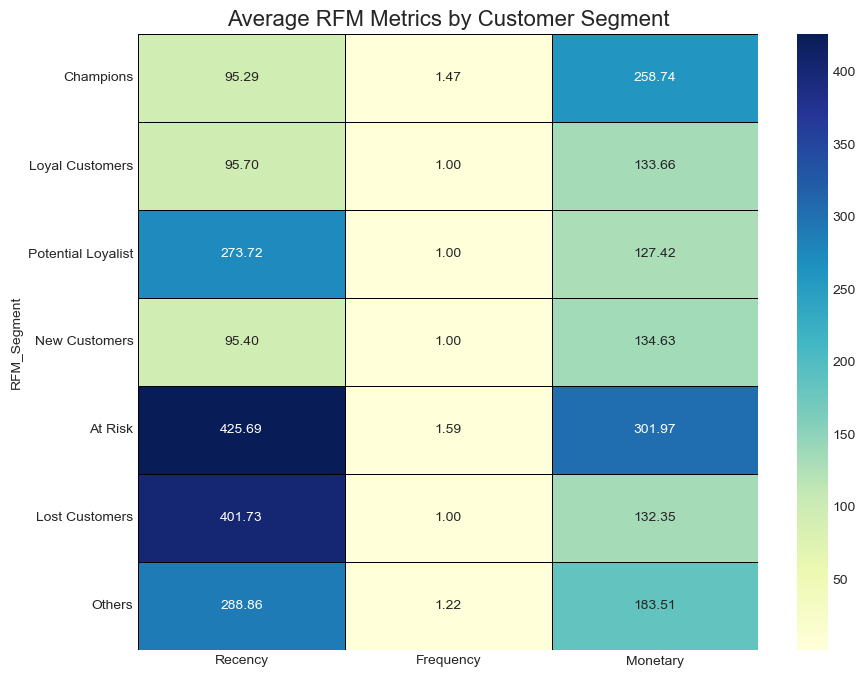

In [23]:
# Set a stylish color palette for the plots
sns.set_palette("viridis")
plt.style.use('seaborn-v0_8-whitegrid')

# Calculate the mean RFM values for each segment
segment_means = rfm_df.groupby('RFM_Segment')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Define the correct segment order based on your actual segments
segment_order = ['Champions', 'Loyal Customers', 'Potential Loyalist', 'New Customers', 'At Risk', 'Lost Customers', 'Others']
segment_means['RFM_Segment'] = pd.Categorical(segment_means['RFM_Segment'], categories=segment_order, ordered=True)
segment_means = segment_means.sort_values('RFM_Segment')

# Set the Segment column as the index for the heatmap
segment_means = segment_means.set_index('RFM_Segment')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(segment_means, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5, linecolor='black')
plt.title('Average RFM Metrics by Customer Segment', fontsize=16)
plt.show()

## Heatmap: Average RFM Metrics by Segment

**Chart Description**:  
This heatmap displays the **average Recency, Frequency, and Monetary** scores for each customer segment. The color intensity reflects the magnitude of each metric.

**Key Insights**:
- **Champions** have the lowest Recency (most recent purchases) and high Monetary values, confirming their top-tier status.
- **At Risk** customers show high Frequency and Monetary scores but poor Recency, indicating they were once valuable but haven’t purchased recently.
- **Lost Customers** have high Recency and low Frequency/Monetary scores, suggesting churn.
- **Potential Loyalists** and **New Customers** show promising behavior with moderate scores across the board.
- The **Others** segment serves as a catch-all for customers who don’t fit neatly into other categories.

##  Step 13: What Do Customers Buy?

Understanding what each customer segment buys—and how much they spend—is essential for crafting targeted marketing strategies.

###  Why These Visuals?
- **Bar charts** show top product categories by purchase count and total spend.
- They reveal what drives engagement and revenue for each segment.

This dual-view approach ensures we don’t just chase volume, but also value.


In [24]:

segmented_final_df = pd.merge(final_df, rfm_df[['customer_unique_id', 'RFM_Segment']], on='customer_unique_id')

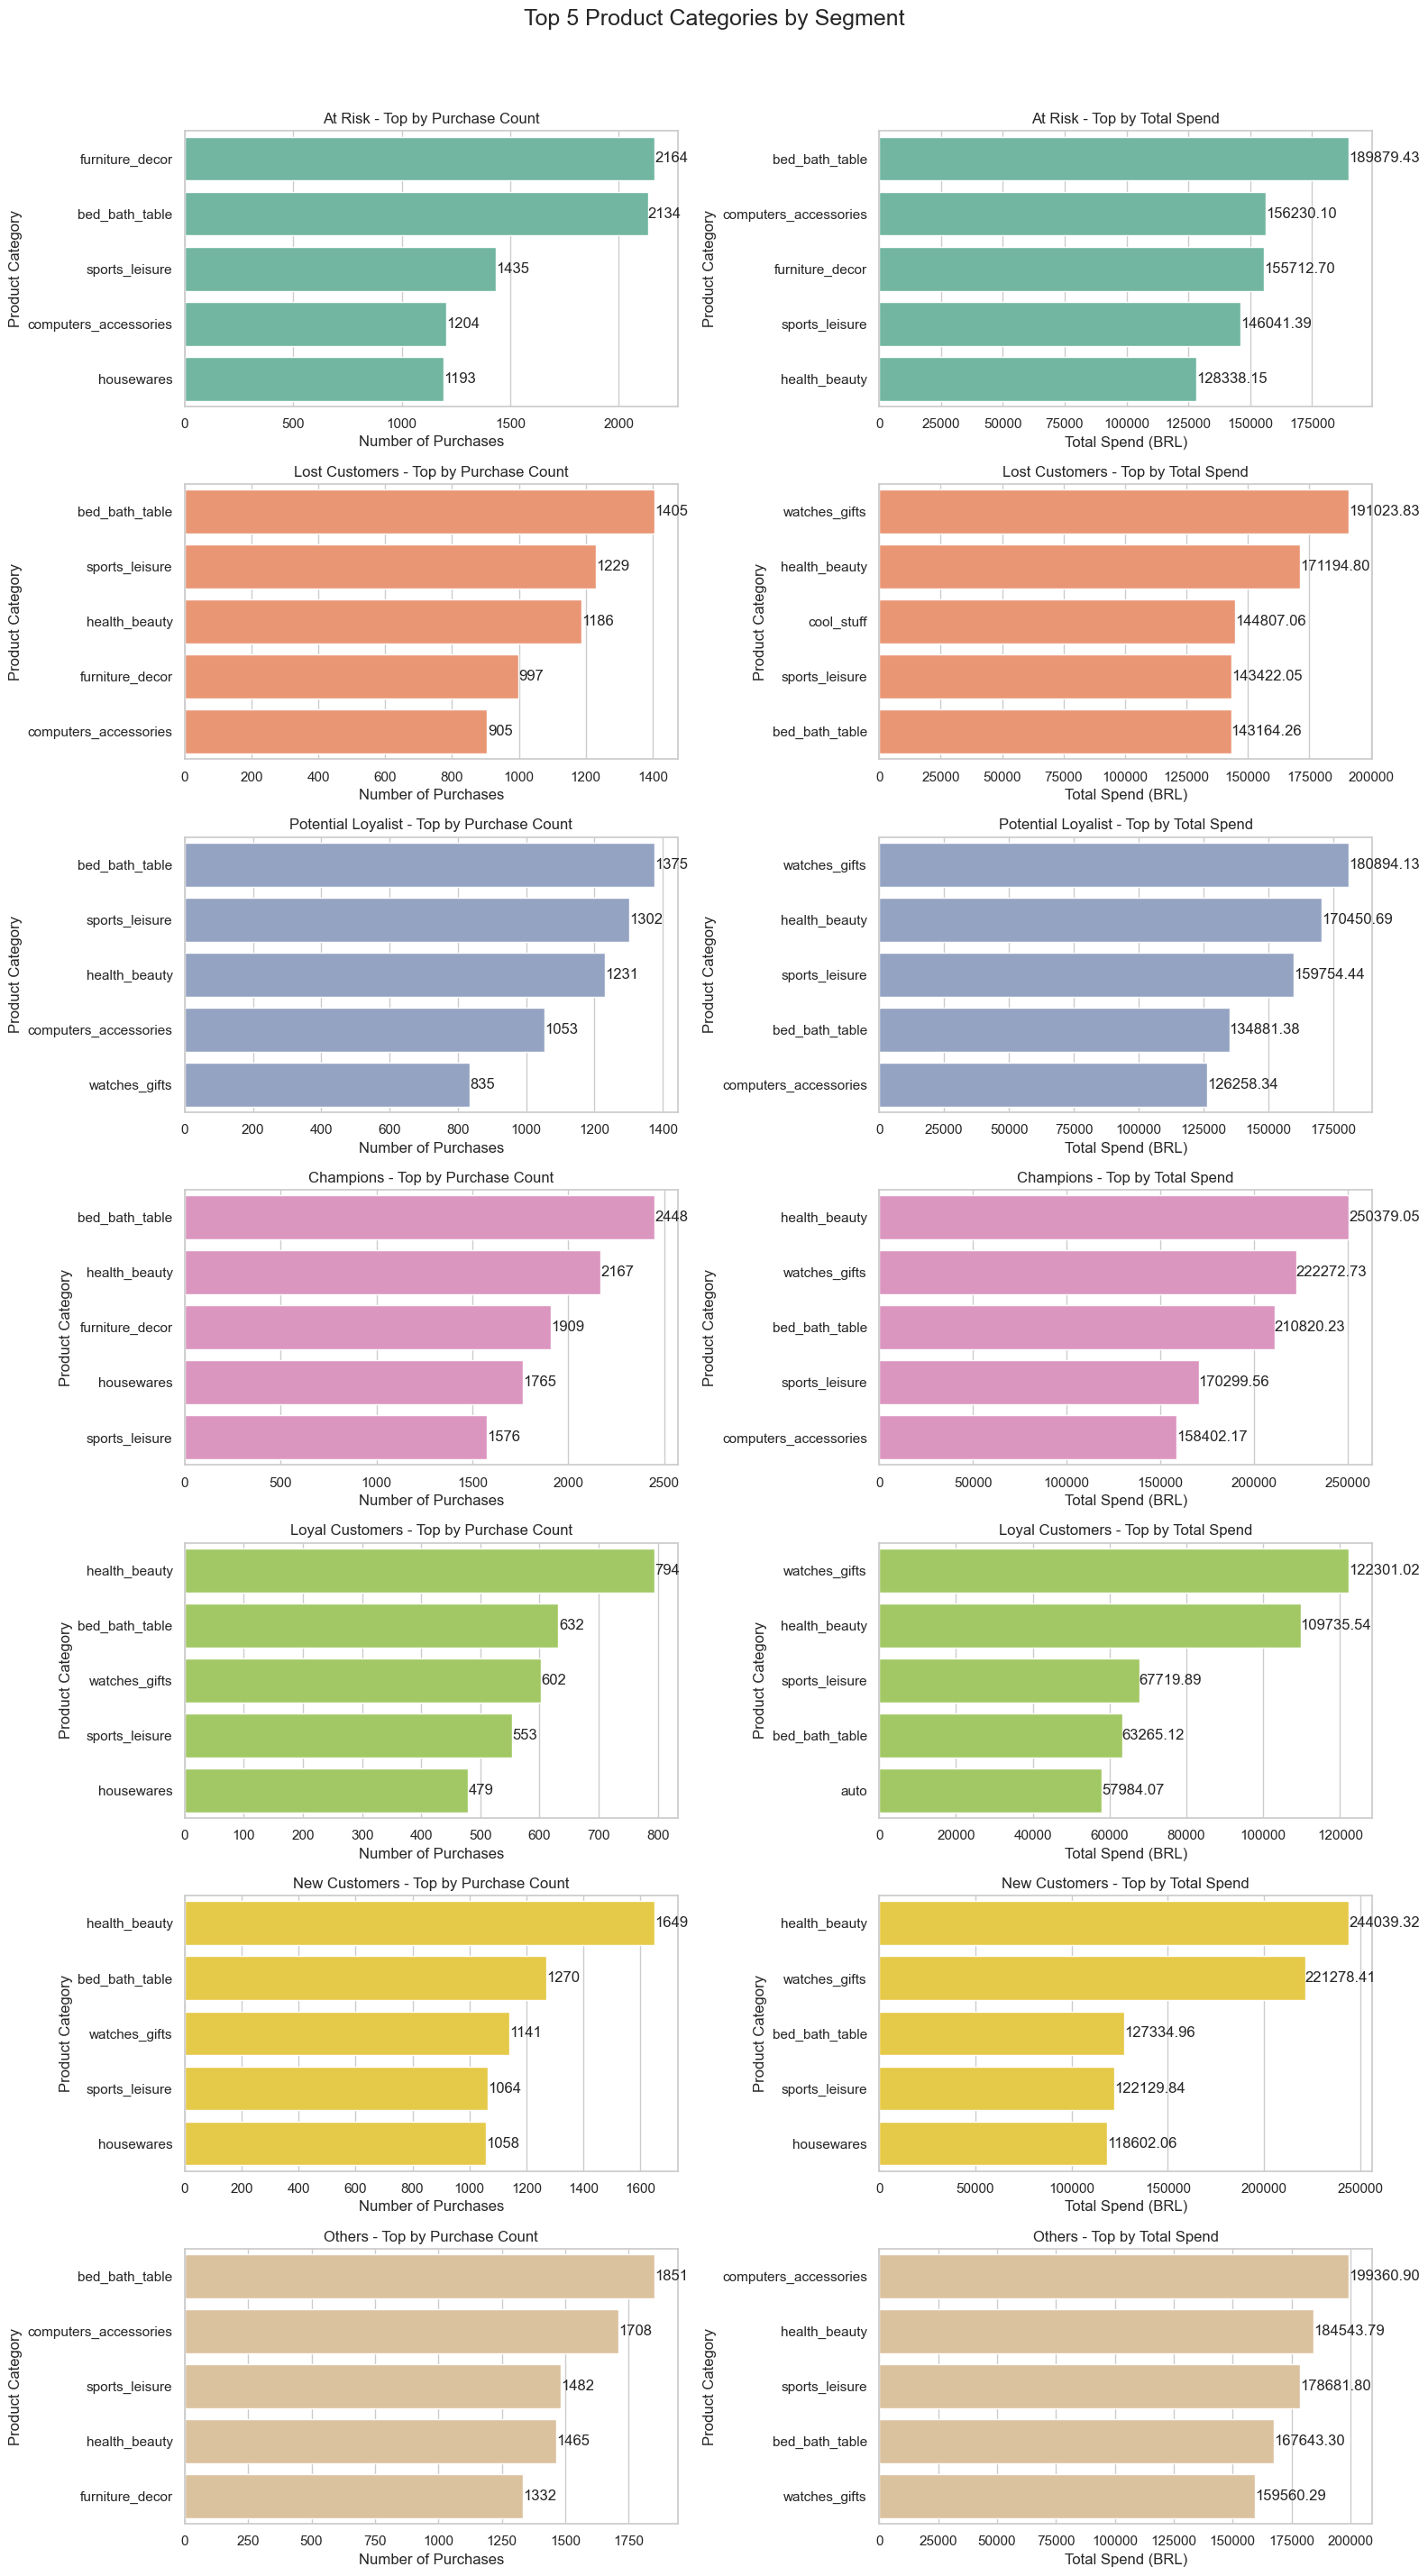

In [25]:
# Set up style
sns.set(style="whitegrid")
segments = segmented_final_df['RFM_Segment'].unique()
palette = sns.color_palette("Set2", len(segments))

# Create subplots
fig, axes = plt.subplots(nrows=len(segments), ncols=2, figsize=(16, len(segments)*4))
fig.suptitle("Top 5 Product Categories by Segment", fontsize=18, y=1.02)

# Loop through each segment
for i, segment in enumerate(segments):
    segment_df = segmented_final_df[segmented_final_df['RFM_Segment'] == segment]
    
    # Top 5 by purchase count
    top_by_count = segment_df['product_category_name_english'].value_counts().head(5)
    
    # Top 5 by total spend
    top_by_spend = segment_df.groupby('product_category_name_english')['price'].sum().sort_values(ascending=False).head(5)
    
    # Plot count
    sns.barplot(
        x=top_by_count.values,
        y=top_by_count.index,
        ax=axes[i, 0],
        palette=[palette[i]] * 5
    )
    axes[i, 0].set_title(f"{segment} - Top by Purchase Count")
    axes[i, 0].set_xlabel("Number of Purchases")
    axes[i, 0].set_ylabel("Product Category")
    
    # Add data labels for count
    for j, value in enumerate(top_by_count.values):
        axes[i, 0].text(value + 1, j, str(value), va='center')

    # Plot spend
    sns.barplot(
        x=top_by_spend.values,
        y=top_by_spend.index,
        ax=axes[i, 1],
        palette=[palette[i]] * 5
    )
    axes[i, 1].set_title(f"{segment} - Top by Total Spend")
    axes[i, 1].set_xlabel("Total Spend (BRL)")
    axes[i, 1].set_ylabel("Product Category")
    
    # Add data labels for spend
    for j, value in enumerate(top_by_spend.values):
        axes[i, 1].text(value + 1, j, f"{value:.2f}", va='center')

plt.tight_layout()
plt.show()


### Key Findings from the Product Category Analysis
- Champions and Loyal Customers consistently purchase high-end categories like bed_bath_table, health_beauty, and furniture_decor, indicating strong interest in home and wellness products.

- At Risk and Lost Customers previously favored similar categories, suggesting they were once valuable buyers. Their drop-off may be due to lack of engagement or shifting needs.

- New Customers tend to explore entry-level categories like housewares and sports_leisure, which could be used as onboarding hooks.

- Potential Loyalists show a mix of interest in computers_accessories and office_furniture, hinting at professional or productivity-driven purchases.

- These insights can guide personalized email campaigns, product bundling strategies, and even regional inventory planning.

## Part 5: Geographic Segmentation

In [26]:
location_segment = segmented_final_df.groupby(['customer_state', 'RFM_Segment'])['customer_unique_id'].nunique().reset_index()
location_segment.rename(columns={'customer_unique_id': 'Customer Count'}, inplace=True)


##  Step 14: Where Are Our Customers?

Segmenting customers by location helps us understand regional behavior and tailor marketing strategies accordingly.

###  Why This Visual?
- The heatmap shows segment distribution across Brazilian states.
- It reveals geographic trends in engagement, loyalty, and churn.


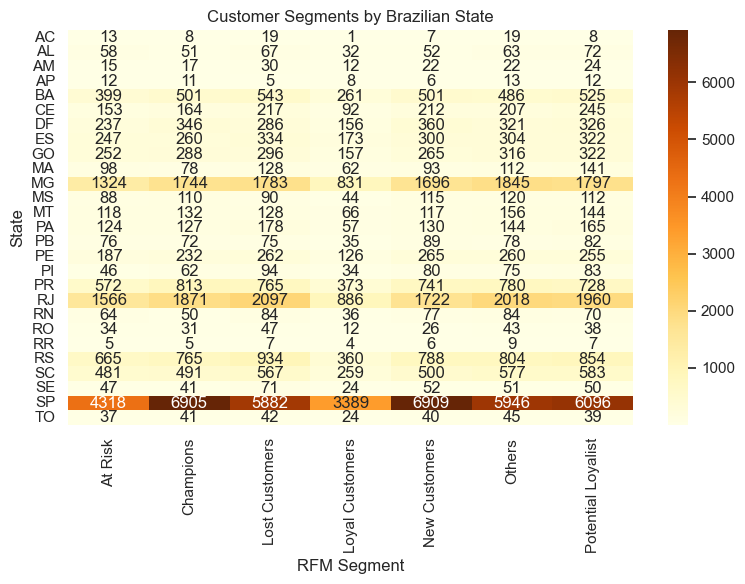

In [27]:
heatmap_data = location_segment.pivot(index='customer_state', columns='RFM_Segment', values='Customer Count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap='YlOrBr', annot=True, fmt='.0f')
plt.title('Customer Segments by Brazilian State')
plt.xlabel('RFM Segment')
plt.ylabel('State')
plt.tight_layout()
plt.show()



###  Key Findings from Location-Based Segmentation
Mapping segments to Brazilian states reveals regional trends. It helps tailor marketing and logistics strategies by geography.


- **Lost Customers** are heavily concentrated in São Paulo (SP), Rio de Janeiro (RJ), and Minas Gerais (MG), suggesting these high-population states may be experiencing disengagement. This could be due to increased competition, delivery issues, or shifting consumer needs.
- **Champions** and **Loyal Customers** are more evenly distributed, indicating that high-value customers exist across multiple regions—not just urban centers.
- The heatmap visualization reveals that some states have a higher proportion of **At Risk** or **Potential Loyalist** customers, which can guide localized re-engagement campaigns.

###  Strategic Implications

- **Regional Campaigns**: Design state-specific promotions to win back Lost Customers in SP and RJ.
- **Inventory Planning**: Align product availability with segment preferences in each region.
- **Customer Service Optimization**: Investigate whether delivery delays or service issues are contributing to churn in certain states.

Segmenting by location transforms generic insights into targeted actions—making your marketing smarter and your operations more efficient.


# Part 6: Behavioral Trends Over Time

###  Step 15: How Do Segments Evolve Over Time?

Tracking monthly segment distribution helps us detect seasonality, churn spikes, and campaign impact.

#### 🔍 Why This Visual?
- Line plots show how customer behavior shifts month-to-month.
- They help evaluate marketing effectiveness and retention efforts.


<Figure size 600x400 with 0 Axes>

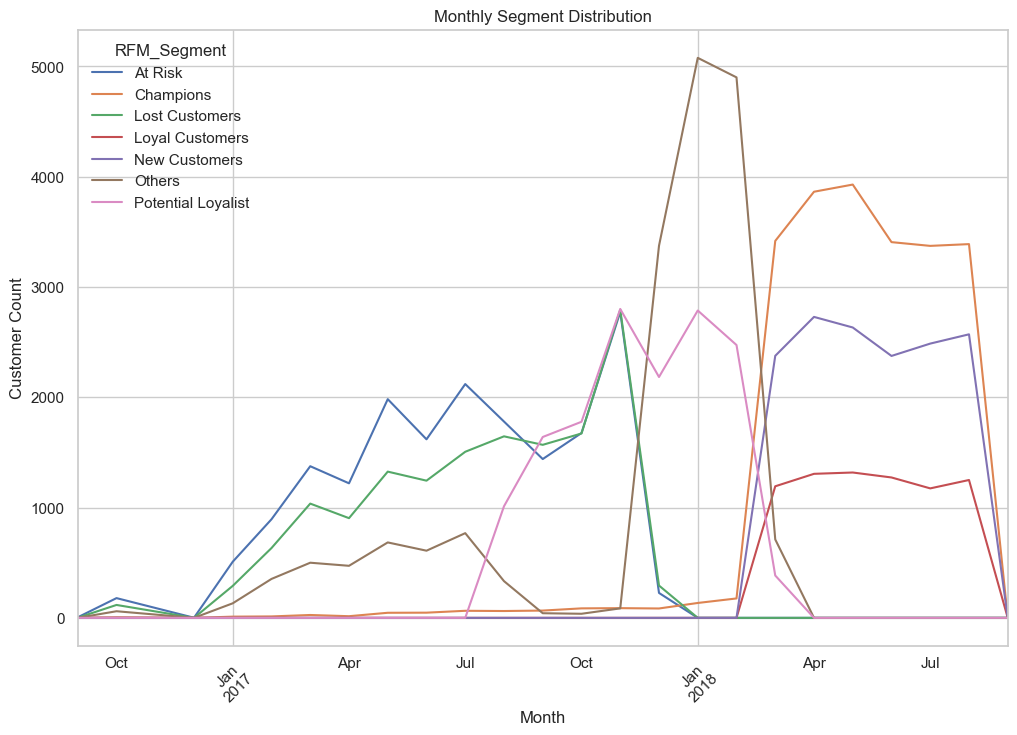

In [28]:
segment_trend = segmented_final_df.copy()
segment_trend['Month'] = segment_trend['order_purchase_timestamp'].dt.to_period('M')
monthly_segment = segment_trend.groupby(['Month', 'RFM_Segment']).size().unstack().fillna(0)

plt.figure(figsize=(6, 4))
monthly_segment.plot()
plt.title('Monthly Segment Distribution')
plt.xlabel('Month')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.show()


# Key Findings

- Segment sizes fluctuate over time.
- New Customers increase during promotional periods.
- Lost Customers rise when engagement drops.


#  Final Analysis Summary: Understanding Customer Purchase Behavior

This customer segmentation analysis using the RFM model has revealed rich, actionable insights into how Brazilian consumers interact with the Olist e-commerce platform. By examining Recency, Frequency, and Monetary metrics, we were able to classify customers into meaningful behavioral segments and uncover patterns that inform strategic business decisions.

###  Segment Profiles & Value
- **Champions** are recent, frequent, and high-spending customers. They represent the most valuable group and should be nurtured with loyalty programs and exclusive offers.
- **At Risk** customers, while currently disengaged, have the highest average spend historically. This makes them prime candidates for reactivation campaigns.
- **Lost Customers** show long periods of inactivity and low frequency, but previously favored high-value categories. Understanding their drop-off can guide win-back strategies.
- **New Customers** are recent but infrequent buyers. They require onboarding and trust-building to convert into loyal customers.
- **Potential Loyalists** exhibit moderate frequency and monetary value, suggesting they are on the verge of becoming high-value if properly engaged.

###  Product Preferences by Segment
- Champions and Loyal Customers gravitate toward home and wellness categories such as **bed_bath_table**, **health_beauty**, and **furniture_decor**.
- Lost Customers previously favored similar categories, indicating a shift in engagement rather than interest.
- New Customers explore entry-level categories like **housewares** and **sports_leisure**, ideal for introductory promotions.
- Potential Loyalists show interest in **computers_accessories** and **office_furniture**, hinting at professional or productivity-driven purchases.

###  Geographic Insights
- **Lost Customers** are heavily concentrated in São Paulo (SP), Rio de Janeiro (RJ), and Minas Gerais (MG), suggesting regional disengagement possibly due to competition or service issues.
- **Champions** are more evenly distributed across states, indicating that high-value customers exist beyond urban centers.
- States with high proportions of **At Risk** or **Potential Loyalists** offer opportunities for localized re-engagement campaigns.

###  Behavioral Trends Over Time
- Segment sizes fluctuate monthly, with **New Customers** peaking during promotional periods.
- **Lost Customers** tend to rise when engagement drops, highlighting the need for consistent retention efforts.
- Tracking these trends helps evaluate the impact of marketing campaigns and seasonal shifts.

###  Strategic Recommendations
- **Retention Focus**: Prioritize At Risk and Potential Loyalists with personalized reactivation offers. Our analysis shows these segments have recently made a purchase (high Recency) but are not yet frequent buyers (low Frequency), making them ideal for nurturing to prevent churn.
- **Loyalty Programs**: Reward Champions to maintain their engagement and spending.
- **Win-Back Campaigns**: Target Lost Customers in SP, RJ, and MG with tailored incentives.
- **Product Strategy**: Align inventory and promotions with segment-specific preferences.
- **Regional Marketing**: Customize outreach based on geographic segment distribution.

---

This analysis not only segments customers but also tells a story of their journey, preferences, and potential. It equips Olist with the insights needed to move from reactive marketing to proactive, data-driven engagement.

